# Analyze 100m and 200m all-time men lists to study whether a linear relation between 100m and 200m PBs can be established # 

In [ ]:
import requests
import lxml.html as lh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split

### Scraping the data from the IAAF website to build Pandas DataFrames. This part of the code has been adapted from: https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059 ###

In [156]:
# get url and create a page
url1='http://www.iaaf.org/records/all-time-toplists/sprints/100-metres/outdoor/men/senior?page=1'
url2='http://www.iaaf.org/records/all-time-toplists/sprints/200-metres/outdoor/men/senior?page=1'
# need this header to open the page from my laptop
headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:64.0) Gecko/20100101 Firefox/64.0'}
page1 = requests.get(url1, headers=headers)
page2 = requests.get(url2, headers=headers)

# store the contents of the website
doc1 = lh.fromstring(page1.content)
doc2 = lh.fromstring(page2.content)

# parse data that are stored between <tr>..</tr> of HTML
tr1_elements = doc1.xpath('//tr')
tr2_elements = doc2.xpath('//tr')

# in our case the table starts at position 18 (with the header)
tr1_elements = tr1_elements[18:]
tr2_elements = tr2_elements[18:]

# create final lists
tr1_elements_final=tr1_elements[:]
tr2_elements_final=tr2_elements[:]

# number of pages of results we want to include from the IAAF website
npage=15

ip=2
while ip<=npage:
    url1='http://www.iaaf.org/records/all-time-toplists/sprints/100-metres/outdoor/men/senior?page=' + str(ip)
    url2='http://www.iaaf.org/records/all-time-toplists/sprints/200-metres/outdoor/men/senior?page=' + str(ip)
    page1 = requests.get(url1, headers=headers)
    page2 = requests.get(url2, headers=headers)
    doc1 = lh.fromstring(page1.content)
    doc2 = lh.fromstring(page2.content)
    tr1_elements_tmp = doc1.xpath('//tr')
    tr2_elements_tmp = doc2.xpath('//tr')
    
    # without including the header again
    tr1_elements_final += tr1_elements_tmp[19:]
    tr2_elements_final += tr2_elements_tmp[19:]
    ip+=1

In [123]:
# create empty list
col1=[]
col2=[]

#For each row, store each first element (header) and an empty list
i=0
for t in tr1_elements_final[0]:
    i+=1
    name=t.text_content()
    name=name.strip()
    #print '%d:"%s"'%(i,name)
    col1.append((name,[]))

i=0
for t in tr2_elements_final[0]:
    i+=1
    name=t.text_content()
    name=name.strip()
    #print '%d:"%s"'%(i,name)
    col2.append((name,[]))

In [124]:
#Since our first row is the header, data is stored on the second row onwards
for j in range(1,len(tr1_elements_final)):
    #T is our j'th row
    T=tr1_elements_final[j]
    
    #If row is not of size 11, the //tr data is not from our table 
    if len(T)!=11:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content()
        data=data.strip()
        #Append the data to the empty list of the i'th column
        col1[i][1].append(data)
        #Increment i for the next column
        i+=1
        
for j in range(1,len(tr2_elements_final)):
    #T is our j'th row
    T=tr2_elements_final[j]
    
    #If row is not of size 11, the //tr data is not from our table 
    if len(T)!=11:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content()
        data=data.strip()
        #Append the data to the empty list of the i'th column
        col2[i][1].append(data)
        #Increment i for the next column
        i+=1

In [125]:
Dict1={title:column for (title,column) in col1}
Dict2={title:column for (title,column) in col2}

# there's a key with all blank entries so we get rid of it
del Dict1['']
del Dict2['']

# create DataFrames
df1=pd.DataFrame(Dict1)
df2=pd.DataFrame(Dict2)

# changing header name
df1.rename(columns={'Mark':'100m'}, inplace=True)
df2.rename(columns={'Mark':'200m'}, inplace=True)

### Creating combined 100-200m list and preparing for regression ###

In [126]:
df3=pd.merge(df1[['Competitor','100m']], df2[['Competitor','200m']], on='Competitor')

Text(0,0.5,u'200m (s)')

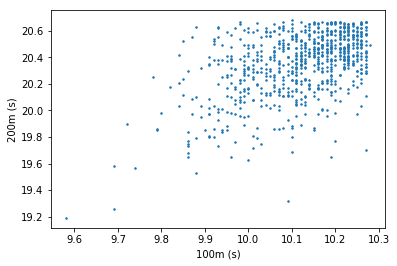

In [127]:
# convert to float
df3 = df3.astype({'100m': float, '200m': float})

# create X and Y arrays for regression
Xval = df3['100m']
Yval = df3['200m']

# split X into random train and test sets
X_train, X_test, y_train, y_test = train_test_split(Xval,Yval,test_size=0.3)

# scatter plot
ax = df3.plot(x='100m', y='200m', style='.', ms=3, legend=False)
ax.set_xlabel("100m (s)")
ax.set_ylabel("200m (s)")

### Performing linear regression using Statsmodels and adapting code from https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9 ###

In [195]:
#Xvalconst = sm.add_constant(Xval)

#modelsm = sm.OLS(Yval, Xvalconst).fit()

#Ypredictionssm = modelsm.predict(Xvalconst)
#modelsm.summary()

In [194]:
#modelsm.predict([[1.0,9.90]])

### Performing linear regression using scikit-learn LinearRegression and adapting code from https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9 ###

In [139]:
# LinearRegression
lm = linear_model.LinearRegression()
lm.fit(X_train.values.reshape(-1,1),y_train)

# model predictions of test set
Ypredictionslm = lm.predict(X_test.values.reshape(-1,1))

In [178]:
# get R-squared
R2lm=lm.score(X_train.values.reshape(-1,1),y_train)
print 'R2_lm = ',R2lm

# get slope
coeflm=lm.coef_
print 'coeff_lm = ',coeflm

# get intercept
constlm=lm.intercept_
print 'intercept_lm = ',constlm

# test model for a random input
lm.predict([[11.00]])

R2_lm =  0.24728785222780536
coeff_lm =  [1.00422826]
intercept_lm =  10.204044448754285


array([21.25055533])

### Performing linear regression using scikit-learn SGDRegressor (Stochastic Gradient Descent) ### 

In [187]:
# SGDRegressor
clf = linear_model.SGDRegressor(max_iter=1000, tol=1e-3)
clf.fit(X_train.values.reshape(-1,1),y_train)

# model predictions of test set
Ypredictionsclf = clf.predict(X_test.values.reshape(-1,1))

In [208]:
# get R-squared
R2clf=clf.score(X_train.values.reshape(-1,1),y_train)
print 'R2_clf = ',R2clf

# get slope
coefclf=clf.coef_
print 'coeff_clf = ',coefclf

# get intercept
constclf=clf.intercept_
print 'intercept_clf = ',constclf

# test model for a random input
clf.predict([[11.00]])

R2_clf =  -0.06891605825267977
coeff_clf =  [1.98643299]
intercept_clf =  [0.20192518]


array([22.05268807])

### Comparison between LinearRegression and SGDRegressor ###

In [143]:
# % difference between truth and predictions for test set for LinearRegressions
lmdiff=100*(y_test-Ypredictionslm)/y_test

# % difference between truth and predictions for test set for SGDRegressor
clfdiff=100*(y_test-Ypredictionsclf)/y_test

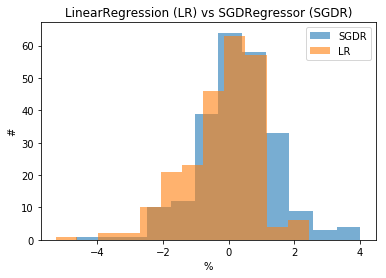

In [204]:
plt.hist(clfdiff, bins=12, alpha=0.6, label='SGDR')
plt.hist(lmdiff, bins=12, alpha=0.6, label='LR')
plt.legend(loc='upper right')
plt.title('LinearRegression (LR) vs SGDRegressor (SGDR)')
plt.xlabel('%')
plt.ylabel('#')
plt.show()